# Leukamia using wrskc

In [1]:
library("evaluomeR")
library("cancerclass")
library("devtools")
library("dplyr")
library("caret")
library("ggplot2")
library("ggrepel")
library("ggforce")

#install.packages("wrsk-master", repos = NULL, type = "source")
library("wrsk")

options(scipen=10)
options(repr.plot.width=12, repr.plot.height=12)

Cargando paquete requerido: SummarizedExperiment

Cargando paquete requerido: MatrixGenerics

Cargando paquete requerido: matrixStats


Adjuntando el paquete: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles,

In [2]:
getRversion()
packageVersion("wrsk")

[1] '4.4.1'

[1] '0.1.0'

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
data("nci60_k8")
dataset = nci60_k8
head(dataset)
set.seed(13626)

,Description,4701,4700,256,16,4699,6393,6149,286,6415,⋯,5721,6622,5336,1067,6288,5872,5489,78,127,3383
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V1,CNS,5.770000,5.820000,-1.910000,-2.37,4.760000,5.4799900,0.000000,0.610000,5.230000,⋯,2.790000,1.210000,-0.890000,-1.055010,-2.1850100,0.045000,1.990000,2.360000,-1.305000,-0.5400195
V2,CNS,5.039961,5.069961,-1.980039,0.00,4.779961,5.7299510,-0.480039,-3.980039,5.329961,⋯,1.629961,1.599961,-1.060039,-1.055049,-3.4050490,0.874961,2.609961,0.869961,-0.375039,0.4799415
V3,CNS,-1.440000,-1.030000,-0.580000,0.00,0.000000,4.6299900,2.060000,-1.580000,0.000000,⋯,1.920000,-0.260000,0.000000,1.294990,-0.6850098,1.445000,0.200000,1.990000,0.705000,0.3199805
V4,RENAL,-2.420000,-2.420000,-1.880000,-1.02,-2.590000,1.2999900,5.190000,-4.880000,7.020000,⋯,3.200000,1.110000,1.060000,1.414990,-4.4750100,2.365000,1.080000,3.600000,-0.685000,0.1399805
V5,BREAST,-2.955000,-2.955000,-1.235000,0.00,-2.535000,-1.0550098,7.425000,-3.235000,4.395000,⋯,2.865000,1.245000,0.000000,-1.480010,-3.8300098,3.320000,-1.155000,-1.385000,-1.220000,0.4449805
V6,CNS,0.000000,-3.180000,-3.050000,-0.05,-1.170000,0.5899902,4.230000,-5.050000,-0.220000,⋯,2.860000,1.360000,0.000000,-1.425010,-2.2550100,1.615000,-0.970000,1.370000,-2.445000,-1.5400200


In [4]:
dataset_labels = dataset$Description
# Replace "K562B-repro", "K562A-repro" with "LEUKEMIA", and "MCF7A-repro", "MCF7D-repro" with "BREAST". Just relabelling.
dataset <- dataset %>%
  mutate(Description = ifelse(Description %in% c("K562B-repro", "K562A-repro"), "LEUKEMIA", Description))
dataset <- dataset %>%
  mutate(Description = ifelse(Description %in% c("MCF7A-repro", "MCF7D-repro"), "BREAST", Description))
unique(dataset$Description)

[1] "CNS"      "RENAL"    "BREAST"   "NSCLC"    "OVARIAN"  "MELANOMA" "LEUKEMIA"
[8] "COLON"

In [5]:
level_mapping <- c("CNS" = 1, "RENAL" = 2, "COLON" = 3,
                   "MELANOMA" = 4,"NSCLC" = 5, "LEUKEMIA" = 6, 
                   "K562B-repro" = 6, "K562A-repro" = 6, "BREAST" = 7,
                   "MCF7A-repro" = 7, "MCF7D-repro" = 7,  "OVARIAN" = 8
                  )
map_strings_to_numbers <- function(strings) {
    return(as.numeric(level_mapping[strings]))
}
gold_standard_vector = as.vector(unlist(lapply(dataset["Description"], map_strings_to_numbers)))
gold_standard_vector

[1] 1 1 1 2 7 1 1 7 5 5 2 2 2 2 2 2 2 7 5 2 8 4 8 8 8 8 8 5 5 5 6 6 6 6 6 6 6 6
[39] 3 3 3 3 3 3 3 7 7 7 7 5 5 5 4 7 7 4 4 4 4 4 4

# WRSKC <a class="anchor" id="clest"></a>
Execution of Clest over the previous dataset.

In [6]:
k.range = c(3,10)
alpha = 0.2
s = 11.2112753007614
gap_stats = as.numeric(length(k.range[1]:k.range[2]))

In [7]:
calculate_wbcss = function(data, k, s, alpha) {
    set.seed(13606)
    result = suppressWarnings(wrsk(data, k, s, iteration = 15, cutoff = alpha))
    return(sum(result$WBCSS))
}

calculate_gap_statistic = function(data, k.range, s, alpha) {
    wbcss_values = numeric(length(k.range[1]:k.range[2]))
    wbcss_ref_values = numeric(length(k.range[1]:k.range[2]))
    
    for (k in k.range[1]:k.range[2]) {
        # Calculate WBCSS for original data
        wbcss_values[k - k.range[1] + 1] = calculate_wbcss(data, k, s, alpha)
        
        # Permute the data and calculate WBCSS for the permuted dataset
        permuted_data = data[sample(nrow(data)), ]
        wbcss_ref_values[k - k.range[1] + 1] = calculate_wbcss(permuted_data, k, s, alpha)
    }
    
    # Compute Gap Statistic (log(WBCSS_ref) - log(WBCSS))
    gap_stat = log(wbcss_ref_values) - log(wbcss_values)
    
    return(gap_stat)
}

find_optimal_k = function(gap_stat, k.range) {
  optimal_k_index = which.max(gap_stat)
  optimal_k = (k.range[1]:k.range[2])[optimal_k_index]
  return(optimal_k)
}

In [8]:
dataset_matrix = as.matrix(dataset[, -1])
rownames(dataset_matrix) = NULL
gap_stat = calculate_gap_statistic(dataset_matrix, k.range, s, alpha)

print(gap_stat)

[1] -0.001176139 -0.038313688 -0.025925984  0.065357437  0.033675681
[6]  0.064713329 -0.011348055  0.023851892


In [18]:
# Find the optimal k
optimal_k = as.numeric(find_optimal_k(gap_stat, k.range))
print(paste("The optimal k is:", optimal_k))

[1] "The optimal k is: 6"


In [20]:
set.seed(13606)
result = suppressWarnings(wrsk(dataset_matrix, optimal_k, s, iteration = 15, cutoff = alpha))
predicted = result$clusters
predicted

[1] 1 1 3 3 3 3 3 3 3 3 6 1 1 6 6 6 6 5 3 5 3 5 2 6 6 6 2 6 6 1 1 2 2 2 5 5 5 5
[39] 2 2 2 2 2 2 2 2 2 2 2 6 5 5 4 4 4 4 4 4 4 4 4

In [11]:
dataset["Cluster"] = as.factor(as.numeric(predicted))
pca_matrix <- dataset[, !names(dataset) %in% "Cluster"]
r_pca = evaluomeR::performPCA(dataset = pca_matrix)
pca_df = r_pca$dataset_ncp
pca_df$Cluster <- as.factor(dataset$Cluster)
pca_df$Description <- dataset$Description

Parameter 'npc' is null. Computing number of factors automatically:

Number of factors, 'ncp' used is: 35



In [27]:
# Creating shapes for individuals
pca_df <- pca_df %>%
  mutate(
    # Extract the letter from the Description column
    Letter = Description,
    # Map the letter to a number
    GoldStandard = case_when(
      Letter == "CNS" ~ 16,
      Letter == "RENAL" ~ 17,
      Letter == "BREAST" ~ 18,
      Letter == "NSCLC" ~ 19,
      Letter == "OVARIAN" ~ 20,
      Letter == "MELANOMA" ~ 21,
      Letter == "LEUKEMIA" ~ 22,
      Letter == "COLON" ~ 23,       
      TRUE ~ NA_real_  # Else...
    )
  )
pca_df$GoldStandard = as.factor(pca_df$GoldStandard)
head(pca_df)

,Description,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,⋯,Dim.29,Dim.30,Dim.31,Dim.32,Dim.33,Dim.34,Dim.35,Cluster,Letter,GoldStandard
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<fct>
V1,CNS,6.097478,-0.1647514,-2.3625462,-3.7853640,0.9176837,6.4919889,1.4840796,0.2589460,3.4998415,⋯,-0.6967309,-1.8748524,0.9264463,-0.04483378,0.7213328,-0.18457639,0.3644274,1,CNS,16
V2,CNS,5.977258,-1.4124431,-2.6126761,-3.0120919,0.6265247,7.5868320,2.2478333,-0.1085869,3.6182820,⋯,-0.2166457,0.7686252,-0.9808568,-0.86641394,1.0211971,-0.32449799,0.4670006,1,CNS,16
V3,CNS,8.099173,0.6272192,-2.5754395,-0.7765312,4.2457457,2.0342516,3.1462687,-0.1289517,0.3664121,⋯,0.4963585,-1.2001106,1.2801710,-0.44156235,0.6244619,-0.53321457,-0.8435209,3,CNS,16
V4,RENAL,12.058369,-2.0675882,-0.9389058,-4.8318299,7.9733869,0.9990644,-0.8670394,-3.7441178,0.2475365,⋯,0.4133163,2.5161183,-0.3965475,0.48625665,-1.9901873,0.08974292,0.6575116,3,RENAL,17
V5,BREAST,13.947443,-1.1437883,-4.0425461,-3.0270261,6.2188670,-7.3679187,-0.8251566,-3.9419799,-1.0727189,⋯,0.9523690,-0.2816908,-1.1907146,-0.36240900,1.1290450,-0.58478239,-0.5216343,3,BREAST,18
V6,CNS,8.213053,-2.0996348,-3.9458410,-3.5244792,3.5893639,-2.9162137,-0.2791665,-3.1057802,-1.6023299,⋯,-0.8604657,-2.3398188,-1.0171413,0.47675312,0.1367769,1.46226006,2.0742978,3,CNS,16


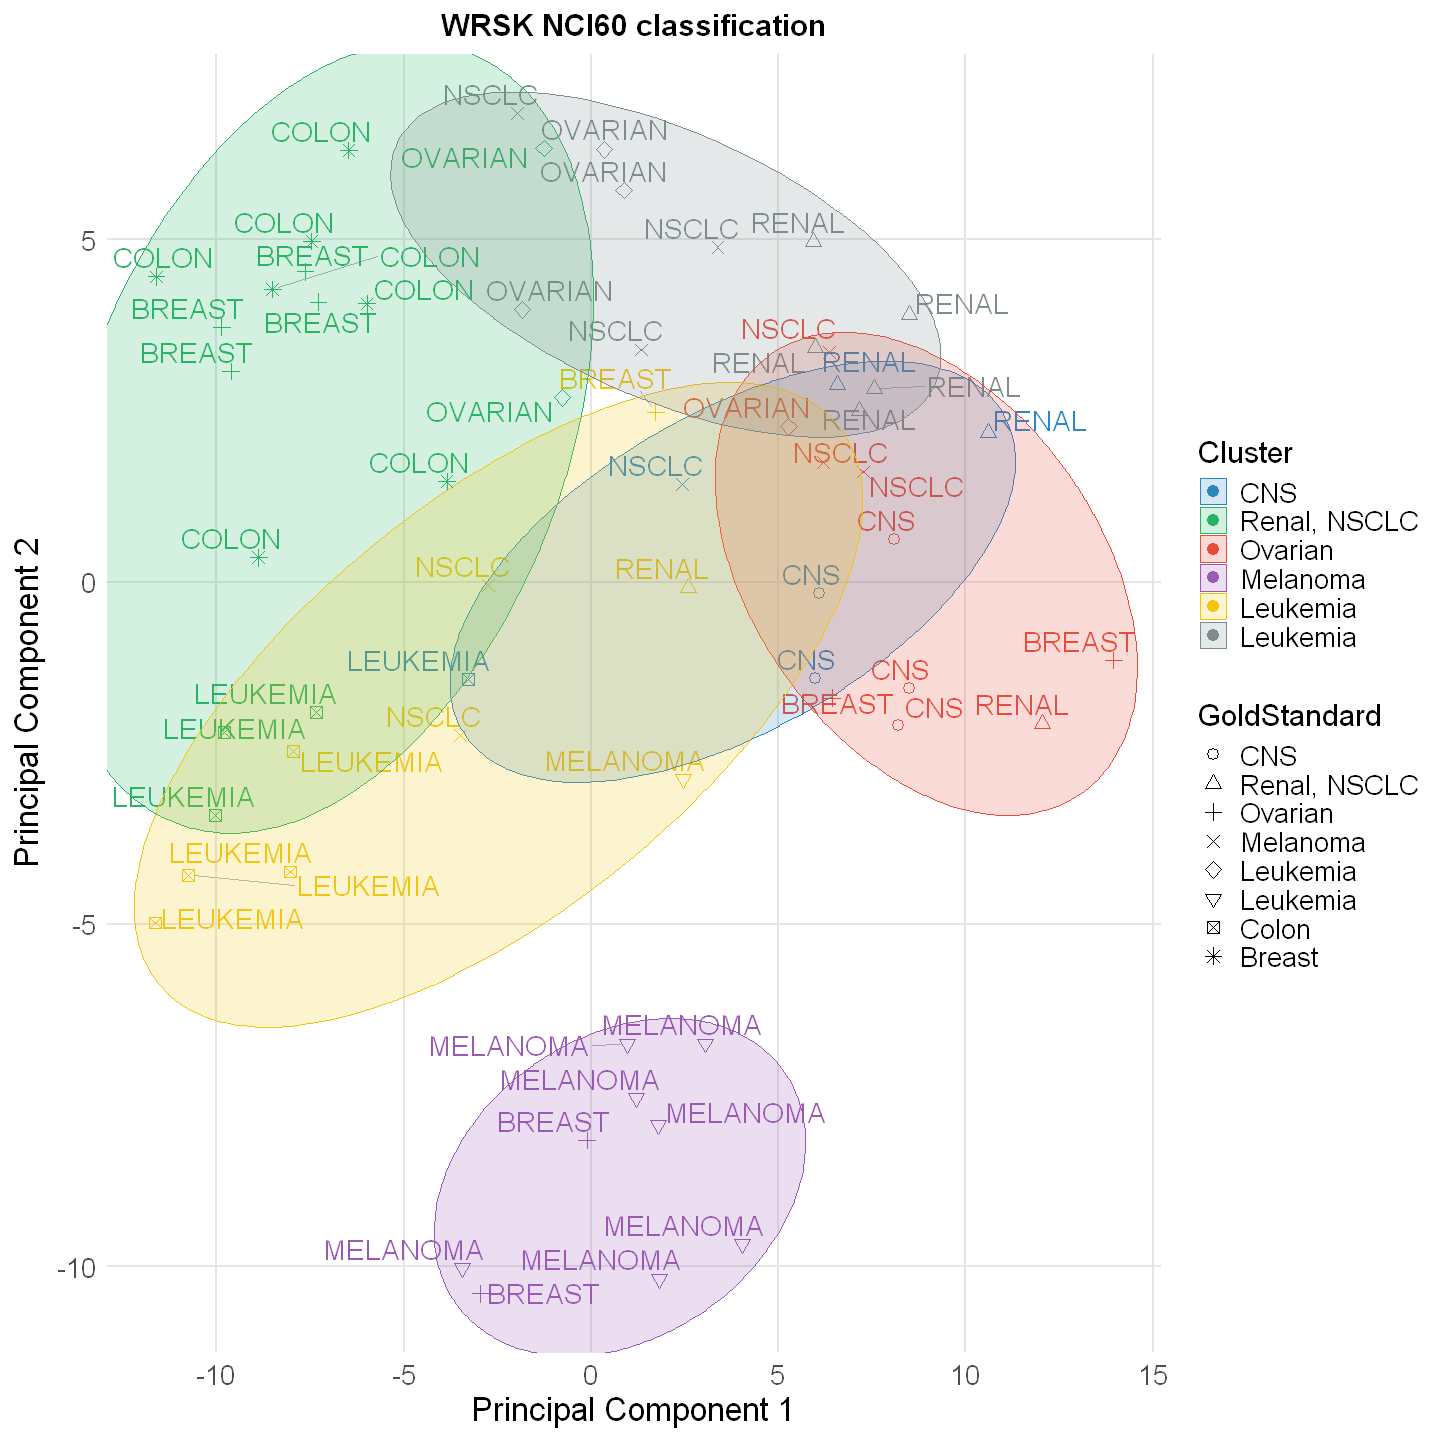

In [45]:
cluster_colors <- c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D", 
                    "#D35400", "#8E44AD", "#16A085")

cluster_shapes <- unique(pca_df$GoldStandard)
cluster_labels <- c("CNS", "Renal, NSCLC", "Ovarian", "Melanoma", "Leukemia", "Leukemia", "Colon", "Breast")

ggplot(pca_df, aes(x = Dim.1, y = Dim.2, shape = GoldStandard, color = Cluster, label = Description)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 6,
    show.legend = FALSE,
    point.padding = 0.4,
    box.padding = 0.25,
    max.overlaps = 20,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  geom_mark_ellipse(aes(group = Cluster, fill = Cluster, label = NULL), alpha = 0.2) +
  labs(
    title = "WRSK NCI60 classification",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = cluster_labels) +
  scale_color_manual(values = cluster_colors, labels = cluster_labels) +
  scale_fill_manual(values = cluster_colors, labels = cluster_labels) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


In [14]:
sen = RSKC::Sensitivity(predicted, gold_standard_vector)
sensitivity_table <- sen$prob[1,]
names(sensitivity_table) = cluster_labels
sensitivity_table
paste0("(", paste(unlist(sensitivity_table), collapse = ","), ")")

,CNS,"Renal, NSCLC",Ovarian,Melanoma,Leukemia,Leukemia,Colon,Breast
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sensitivity. (%),60,56,100,88,33,50,44,50


[1] "(60,56,100,88,33,50,44,50)"

In [15]:
cer = CER(predicted, gold_standard_vector)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 18.96%"


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


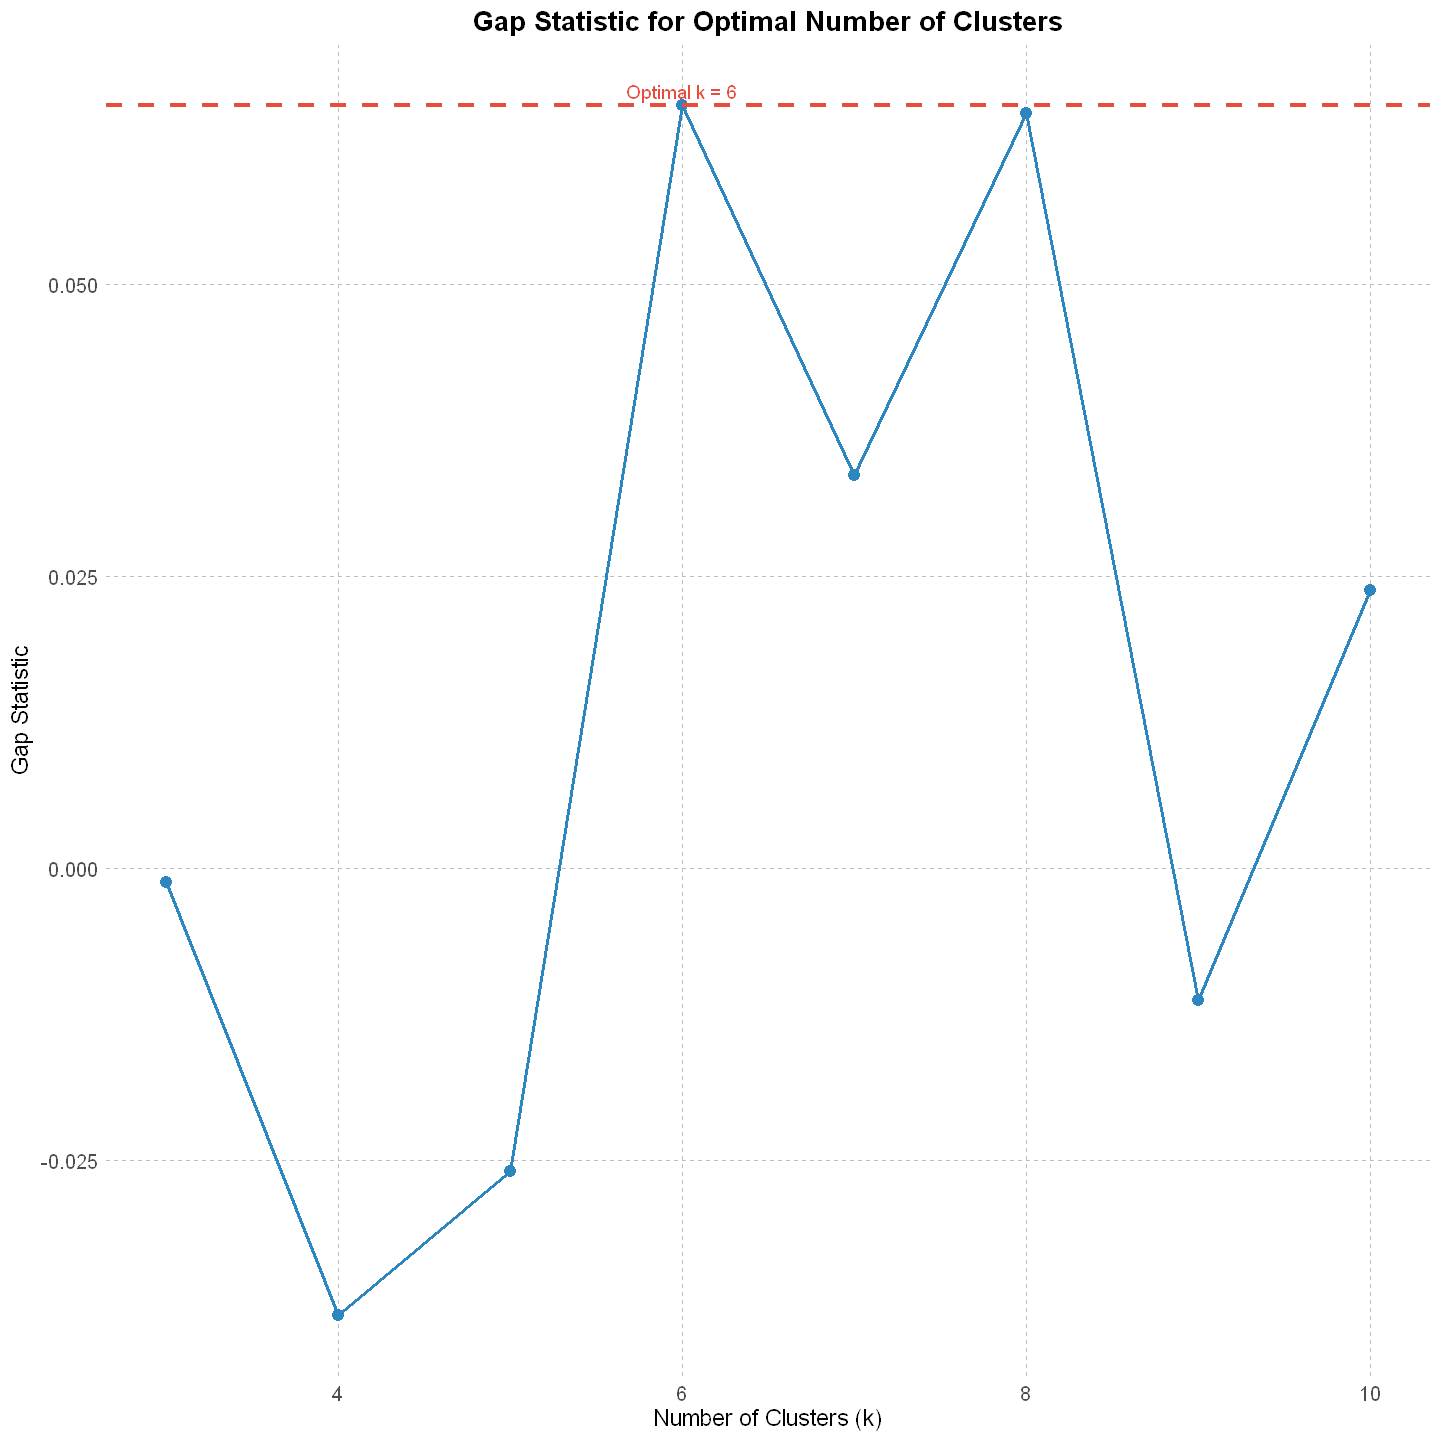

In [16]:
gap_data <- data.frame(
  k = k.range[1]:k.range[2],
  gap_stat = gap_stat
)

# Create the plot using ggplot2
ggplot(gap_data, aes(x = k, y = gap_stat)) +
  geom_point(color = "#2E86C1", size = 3) +  # Plot points
  geom_line(color = "#2E86C1", size = 1) +   # Connect the points with lines
  geom_hline(yintercept = max(gap_stat), color = "#E74C3C", linetype = "dashed", size = 1.2) +  # Red dashed line at max gap statistic
  annotate("text", x = optimal_k, y = max(gap_stat), label = paste("Optimal k =", optimal_k), vjust = -0.5, color = "#E74C3C", size = 4) +  # Label for optimal k
  labs(
    title = "Gap Statistic for Optimal Number of Clusters",
    x = "Number of Clusters (k)",
    y = "Gap Statistic"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    panel.grid.major = element_line(color = "gray", linetype = "dashed", size = 0.5),
    panel.grid.minor = element_blank()
  )